# SVM for High-Dimensional Text Classification

This notebook accompanies the tutorial on using Support Vector Machines (SVM) for high-dimensional text classification.

It contains two main parts:
1. SMS Spam Classification using TF-IDF + LinearSVC
2. Extension: 20 Newsgroups Text Classification with LinearSVC

Each section mirrors the structure of the written tutorial.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# For 20 Newsgroups
from sklearn.datasets import fetch_20newsgroups

## 2. SMS Spam Classification

In this section we build a text classification model on the **Kaggle SMS Spam Collection** dataset.
Make sure you have a `spam.csv` file in the same directory as this notebook.

**Expected columns**:
- `v1`: label (`ham` or `spam`)
- `v2`: text message


### 2.1 Load and inspect the dataset

In [2]:
# Load the dataset
df = pd.read_csv("spam.csv", encoding='latin-1')

# Keep only the relevant columns
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

print(df.head())
print("\nClass distribution:")
print(df['label'].value_counts())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


### 2.2 Train–test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 4457, Test size: 1115


### 2.3 TF-IDF + LinearSVC Pipeline

We now build a pipeline that:
1. Vectorises the text using `TfidfVectorizer`
2. Trains a linear SVM classifier using `LinearSVC`.

In [4]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LinearSVC(C=1.0, random_state=42))
])

pipeline.fit(X_train, y_train)
print("Model trained.")

Model trained.


### 2.4 Evaluation on the test set

In [5]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9838565022421525

Classification report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



### 2.5 Confusion Matrix

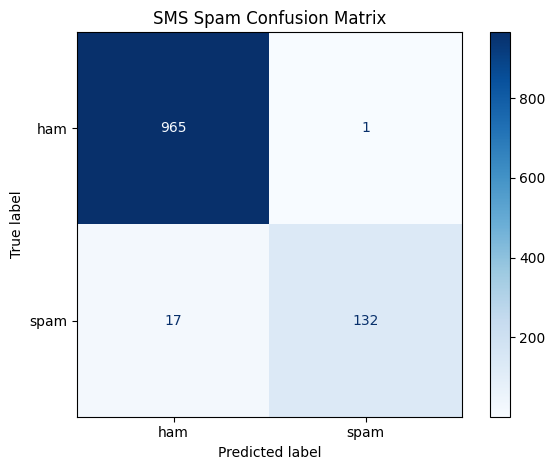

In [6]:
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot(cmap='Blues')
plt.title("SMS Spam Confusion Matrix")
plt.tight_layout()
plt.savefig("figure_confusion_matrix_sms.png", dpi=300)
plt.show()

### 2.6 TF-IDF Matrix Shape and Sparsity

In [7]:
# Fit vectorizer separately to inspect matrix properties
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df['text'])

print("TF-IDF shape:", X_tfidf.shape)
density = X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])
print("Density (non-zero proportion):", density)

TF-IDF shape: (5572, 8404)
Density (non-zero proportion): 0.0009284796868000846


### 2.7 Inspecting Important Features

We can inspect which words are most associated with `spam` vs `ham`.
Note: `LinearSVC` is a linear model, so its coefficients correspond to feature importance.

In [8]:
# Refit pipeline to access underlying steps more easily
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
clf = LinearSVC(C=1.0, random_state=42)
clf.fit(X_train_tfidf, y_train)

feature_names = np.array(tfidf.get_feature_names_out())

# For binary classification, coef_[0] corresponds to one of the classes (sorted internally).
coefs = clf.coef_[0]

# Top spam-indicative features (largest positive coefficients)
top_spam_idx = np.argsort(coefs)[-20:]
top_spam_words = feature_names[top_spam_idx]
top_spam_values = coefs[top_spam_idx]

# Top ham-indicative features (most negative coefficients)
top_ham_idx = np.argsort(coefs)[:20]
top_ham_words = feature_names[top_ham_idx]
top_ham_values = coefs[top_ham_idx]

print("Top spam-like words:")
for w, v in zip(top_spam_words, top_spam_values):
    print(f"{w}: {v:.3f}")

print("\nTop ham-like words:")
for w, v in zip(top_ham_words, top_ham_values):
    print(f"{w}: {v:.3f}")

Top spam-like words:
146tf150p: 1.237
18: 1.254
prize: 1.277
won: 1.277
stop: 1.281
http: 1.340
dating: 1.366
reply: 1.383
88066: 1.387
urgent: 1.398
ac: 1.464
50: 1.582
ringtone: 1.583
mobile: 1.662
www: 1.844
claim: 1.876
150p: 1.910
service: 1.976
txt: 2.386
uk: 2.388

Top ham-like words:
fullonsms: -0.992
liked: -0.989
ll: -0.816
home: -0.802
lt: -0.781
sir: -0.754
gt: -0.751
mail: -0.728
way: -0.705
yup: -0.677
did: -0.627
later: -0.618
morning: -0.606
gd: -0.572
sorry: -0.570
place: -0.557
knowing: -0.539
said: -0.536
hey: -0.534
lunch: -0.528


### 2.8 Plotting Top Feature Importances

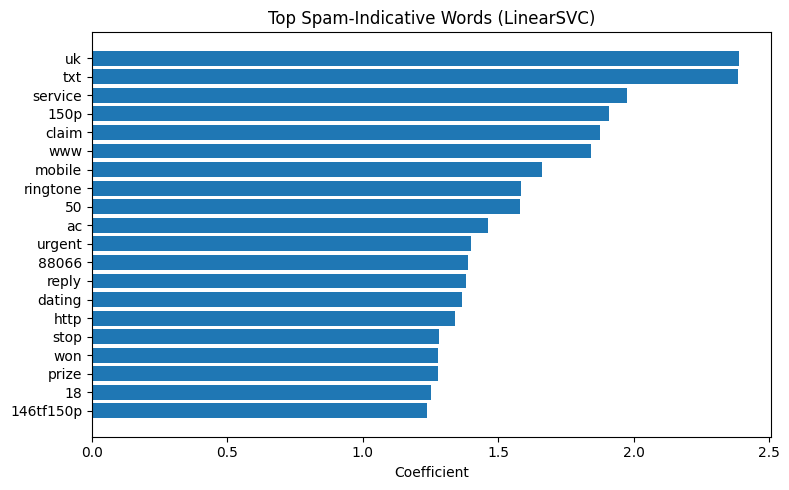

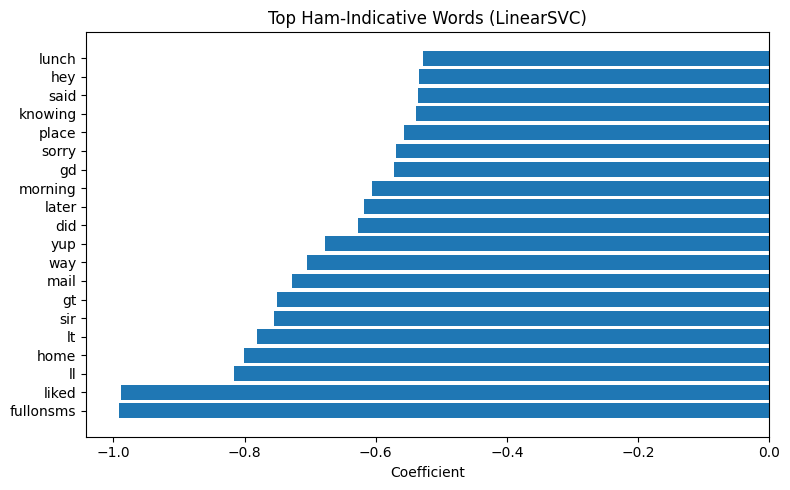

In [9]:
# Plot spam-indicative words
plt.figure(figsize=(8,5))
order = np.argsort(top_spam_values)
plt.barh(top_spam_words[order], top_spam_values[order])
plt.title("Top Spam-Indicative Words (LinearSVC)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.savefig("figure_top_spam_features.png", dpi=300)
plt.show()

# Plot ham-indicative words
plt.figure(figsize=(8,5))
order = np.argsort(top_ham_values)
plt.barh(top_ham_words[order], top_ham_values[order])
plt.title("Top Ham-Indicative Words (LinearSVC)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.savefig("figure_top_ham_features.png", dpi=300)
plt.show()

### 2.9 Exploring the Effect of C (Regularisation)

C=0.1: accuracy=0.9731
C=1: accuracy=0.9839
C=10: accuracy=0.9857


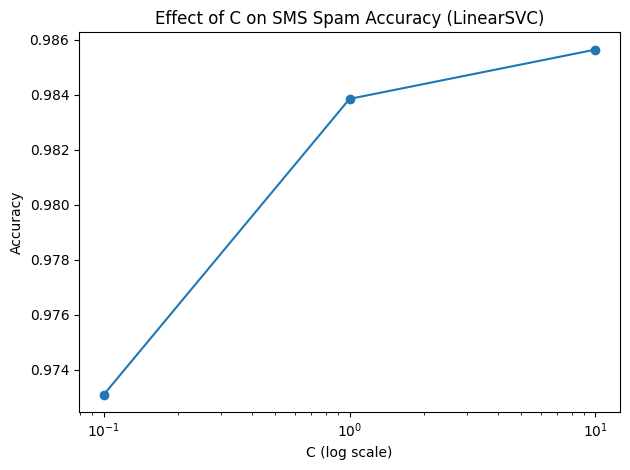

In [10]:
C_values = [0.1, 1, 10]
accuracies = []

for c in C_values:
    clf_c = LinearSVC(C=c, random_state=42)
    clf_c.fit(X_train_tfidf, y_train)
    y_pred_c = clf_c.predict(tfidf.transform(X_test))
    acc = accuracy_score(y_test, y_pred_c)
    accuracies.append(acc)
    print(f"C={c}: accuracy={acc:.4f}")

plt.figure()
plt.plot(C_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("Effect of C on SMS Spam Accuracy (LinearSVC)")
plt.tight_layout()
plt.savefig("figure_accuracy_vs_C_sms.png", dpi=300)
plt.show()

## 3. Extension: 20 Newsgroups Classification

In this optional advanced section, we apply the same TF-IDF + LinearSVC pipeline to the 20 Newsgroups dataset to demonstrate SVM performance on a larger, multi-class, high-dimensional text dataset.

### 3.1 Load the 20 Newsgroups dataset

In [11]:
categories = None
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories,
                                      remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories,
                                     remove=('headers', 'footers', 'quotes'))

print("Number of training documents:", len(newsgroups_train.data))
print("Number of test documents:", len(newsgroups_test.data))
print("Number of classes:", len(newsgroups_train.target_names))

Number of training documents: 11314
Number of test documents: 7532
Number of classes: 20


### 3.2 Train TF-IDF + LinearSVC on 20 Newsgroups

In [12]:
news_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100000)),
    ('clf', LinearSVC(C=1.0, random_state=42))
])

news_pipeline.fit(newsgroups_train.data, newsgroups_train.target)
print("20 Newsgroups model trained.")

20 Newsgroups model trained.


### 3.3 Evaluate on 20 Newsgroups Test Set

In [13]:
news_pred = news_pipeline.predict(newsgroups_test.data)
print("Accuracy (20 Newsgroups):", accuracy_score(newsgroups_test.target, news_pred))

# Show a brief classification report (can be long for 20 classes)
print("\nClassification report (truncated):")
print(classification_report(newsgroups_test.target, news_pred, target_names=newsgroups_train.target_names))

Accuracy (20 Newsgroups): 0.6925119490175252

Classification report (truncated):
                          precision    recall  f1-score   support

             alt.atheism       0.55      0.49      0.52       319
           comp.graphics       0.68      0.74      0.71       389
 comp.os.ms-windows.misc       0.62      0.62      0.62       394
comp.sys.ibm.pc.hardware       0.63      0.65      0.64       392
   comp.sys.mac.hardware       0.73      0.69      0.71       385
          comp.windows.x       0.83      0.70      0.76       395
            misc.forsale       0.73      0.78      0.76       390
               rec.autos       0.74      0.71      0.73       396
         rec.motorcycles       0.78      0.75      0.77       398
      rec.sport.baseball       0.54      0.85      0.66       397
        rec.sport.hockey       0.87      0.87      0.87       399
               sci.crypt       0.86      0.72      0.78       396
         sci.electronics       0.62      0.58      0.60     